## Training File
Do not run this file unless necessary. This will train a new model saved as *saved_model/model-11.h5*. 

In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


In [3]:
imgh = 224
imgw = 224
test_size = 0.3
batch = 32
epoch = 25

In [4]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(imgh, imgw, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(1,activation='sigmoid')(x) #FC-layer

In [5]:
model=Model(inputs=model_d.input,outputs=preds)

In [6]:
for layer in model.layers[:-1]:
    layer.trainable=False
    
for layer in model.layers[-1:]:
    layer.trainable=True

In [7]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("data/Infection")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("data/infection/"+img)))
    for i in path:
        image = cv2.imread("data/infection/"+img+'/'+i)
        image = cv2.resize(image, (imgh,imgw))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['Aug-Positive', 'Aug-Negative']


In [9]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[1]


In [10]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=test_size,random_state=42)
print(xtrain.shape, xtest.shape)

(4116, 224, 224, 3) (1765, 224, 224, 3)


In [11]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch),
               steps_per_epoch= xtrain.shape[0] // 32,
               epochs=epoch,
               verbose=1,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
128/128 [==============================] - ETA: 0s - loss: 0.7244 - accuracy: 0.5333
Epoch 00001: val_loss improved from inf to 0.65711, saving model to model.h5
128/128 [==============================] - 736s 6s/step - loss: 0.7244 - accuracy: 0.5333 - val_loss: 0.6571 - val_accuracy: 0.6215
Epoch 2/25
128/128 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.5561
Epoch 00002: val_loss improved from 0.65711 to 0.65251, saving model to model.h5
128/128 [==============================] - 730s 6s/step - loss: 0.7012 - accuracy: 0.5561 - val_loss: 0.6525 - val_accuracy: 0.6232
Epoch 3/25
128/128 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.5894
Epoch 00003: val_loss improved from 0.65251 to 0.63973, saving model to model.h5
128/128 [==============================] - 729s 6s/step - loss: 0.6790 - accuracy: 0.5894 - val_loss: 0.6397 - val_accuracy: 0.6329
E

In [12]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

print(ytest[0])
print(ypred[0])
for i in range(len(ypred)):
    if np.round(ypred[i]) == ytest[i]:
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

[0]
[0.27076542]
Total-test-data; 1765 	accurately-predicted-data: 1163 	 wrongly-predicted-data:  602
Accuracy: 65.892 %


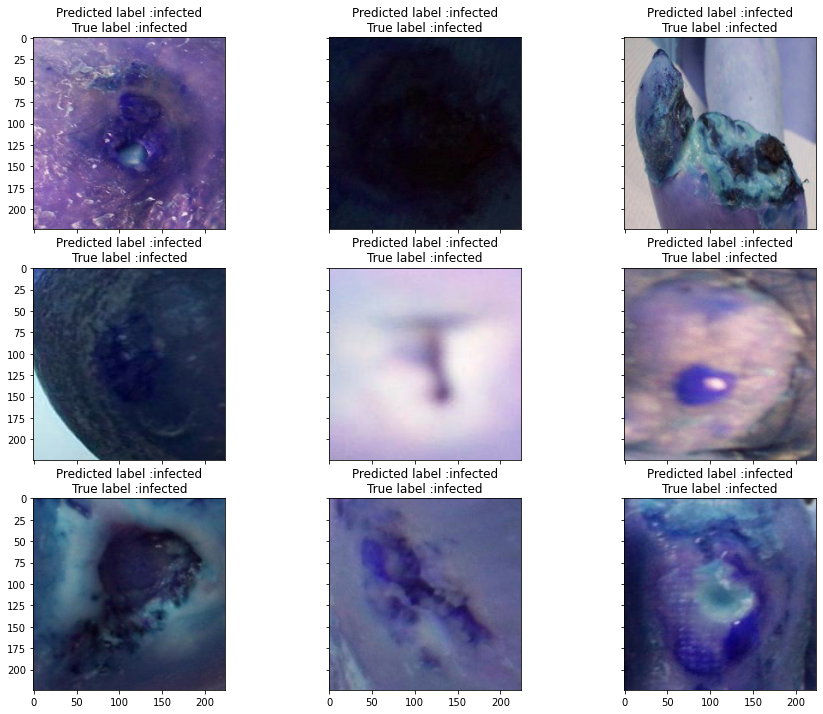

In [13]:
label=['infected', 'not infected']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]], cmap="viridis")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

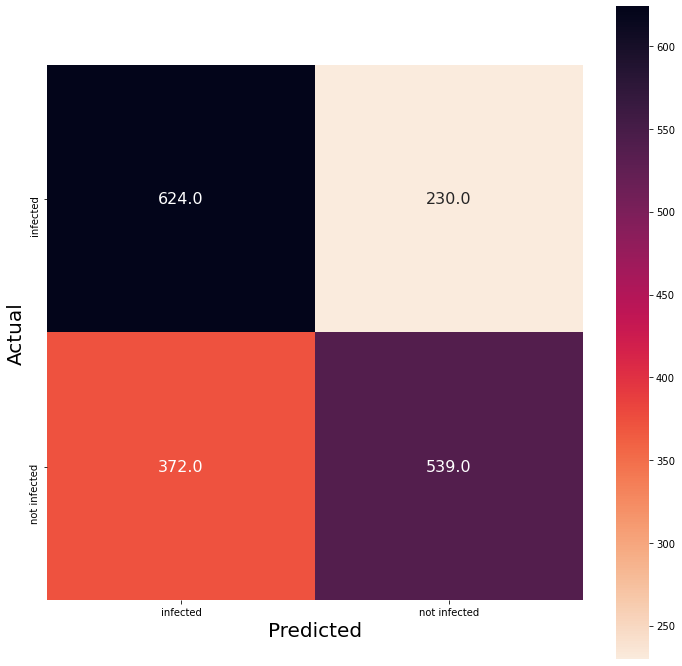

In [14]:
Ypred = model.predict(xtest)

Ypred = np.round(Ypred)
Ytrue = np.round(ytest)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [15]:
model.save('saved_model/model-11.h5')
model.save_weights('saved_model/model-11-weights.h5')

In [16]:
print("Image Size: {0}x{1}x3, {2}-{3} test, epoch {4}, batch size {5}".format(imgh, imgw, (1-test_size)*100, test_size*100, epoch, batch))
print('F1 Score:', round(f1_score(Ytrue, Ypred, average='binary')*100, 3), '%')

Image Size: 224x224x3, 70.0-30.0 test, epoch 25, batch size 32
F1 Score: 64.167 %


Image Size: 224x224x3, 60-40 test, epoch 12, batch size 32. F1-Score: 0.64776

Image Size: 224x224x3, 65-35 test, epoch 12, batch size 32. F1-Score: 0.6759

Image Size: 224x224x3, 70-30 test, epoch 12, batch size 32. F1-Score: 0.67344

Image Size: 224x224x3, 60-40 test, epoch 25, batch size 32. F1-Score: 0.69065

Image Size: 224x224x3, 65-35 test, epoch 25, batch size 32. F1-Score: 0.62961

Image Size: 224x224x3, 70-30 test, epoch 25, batch size 32. F1-Score: 0.64167